In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

In [4]:
data = np.load('data.npy',allow_pickle=True)
target = np.load('target.npy',allow_pickle=True)

In [5]:
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        try:
            data[i,j,10] = int(str(data[i,j,10])[0])
        except:
            data[i,j,10] = 0

In [6]:
for i in range(target.shape[0]):
    try:
        target[i,10] = int(str(target[i,10])[0])
    except:
        target[i,10] = 0

In [7]:
data = data.astype("float")
target = target.astype("float")

In [8]:
data = torch.from_numpy(data).float()
# data = data.permute(0,2,1) # Needed if using CNN
target = torch.from_numpy(target).float()

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)
'''
0:Year,1:ProfitLoss,2:GrossResult,3:GrossProfitLoss,
4:Revenue,5:Assets,6:AverageNumberOfEmployees,7:CurrentAssets,8:Equity,
9:Inventories,10:AddressOfReportingEntityPostCodeIdentifier
'''
train_data = data[train_idx,:,1:]
train_target = target[train_idx,7] 
test_data = data[test_idx,:,1:]
test_target = target[test_idx,7]

trainset = dataset(train_data,train_target)
testset = dataset(test_data,test_target)

In [9]:
train_data.shape

torch.Size([30989, 3, 10])

In [10]:
batch_size=200

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

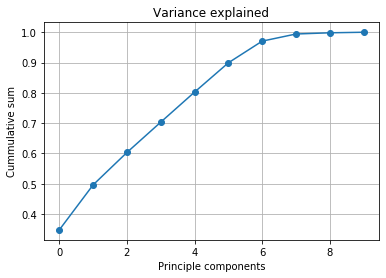

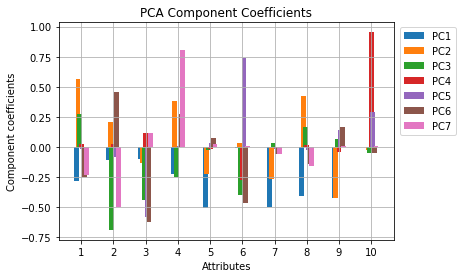

In [11]:
temp = data.clone()
temp = temp.view(temp.shape[0]*temp.shape[1],temp.shape[2])
temp = temp[:,1:temp.shape[1]].numpy()

#standardize data 
temp = temp-np.ones((temp.shape[0],1))*temp.mean(0)
temp = temp*(1/np.std(temp,0))
#compute covariance matrix
S = np.cov(temp.T)

#obtain eigen values and eigen vectors
eigenValues, eigenVectors = eigh(S)
idx_ord = np.argsort(eigenValues)[::-1]
eigenValues = eigenValues[idx_ord]
eigenVectors = eigenVectors[:,idx_ord]

#plot cummulative variance explained    
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(10)
for i in range(10):    
    cumsum = cumsum + eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig, ax = plt.subplots()
ax.plot(total_var_explained,'-o')
#ax.axhline(0.90,linestyle='--')
plt.grid();
#plt.xlim(-1,50)
#plt.ylim(0,1)
plt.title('Variance explained' )
plt.ylabel('Cummulative sum')
plt.xlabel('Principle components')
#plt.savefig("variance_explained")
plt.show()

M=10
pcs = np.arange(7)
#pcs = np.array([3,10])
legendStrs = ['PC'+str(e+1) for e in pcs]
c = ['r','g','b']
bw = .15
r = np.arange(1,M+1)
for i in pcs:    
   plt.bar(r+i*bw/3, eigenVectors[:,i], width=bw)
plt.xticks(r+bw, np.arange(1,13))
plt.xlabel('Attributes')
plt.ylabel('Component coefficients')
plt.legend(legendStrs,loc=1, bbox_to_anchor=(1.2,1))
plt.grid()
plt.title('PCA Component Coefficients')
plt.show()

In [12]:
# #Picking principle components to project the data into
# eigenvectors1 = eigenVectors[:, 0]
# eigenvectors2 = eigenVectors[:, 1]
# eigenvectors3 = eigenVectors[:, 2]
# eigenvectors4 = eigenVectors[:, 3]
# eigenvectors = np.vstack((eigenvectors1,eigenvectors2,eigenvectors3,eigenvectors4)).T

# ## now we have to project our vectors in this new base
# transformed_data = temp @ eigenvectors

# fig,ax = plt.subplots(3,1,figsize=(10,15))
# ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1])
# ax[0].set_title('Data projection into 2D PC space')
# ax[0].set_xlabel('Principle component 1')
# ax[0].set_ylabel('Principle component 2')
# ax[1].scatter(transformed_data[:, 0], transformed_data[:, 2])
# ax[1].set_title('Data projection into 2D PC space')
# ax[1].set_xlabel('Principle component 1')
# ax[1].set_ylabel('Principle component 3')
# ax[2].scatter(transformed_data[:, 0], transformed_data[:, 3])
# ax[2].set_title('Data projection into 2D PC space')
# ax[2].set_xlabel('Principle component 1')
# ax[2].set_ylabel('Principle component 4')
# #plt.rcParams.update({'figure.autolayout': True})
# plt.show()

In [13]:
class RecurrentNet(nn.Module):
    def __init__(self):
        super(RecurrentNet, self).__init__()
        
        self.linearIn = nn.Sequential(nn.Linear(in_features=10,out_features=10),
                                      nn.PReLU(),
                                      nn.Dropout(),
                                      nn.Linear(10,10)) 
        self.rnn = nn.LSTM(input_size=20,
                          hidden_size=50,
                          num_layers=5,
                          batch_first=True,
                          dropout=0.2)
        self.linearOut = nn.Sequential(nn.Linear(in_features=210,out_features=140),
                                       nn.PReLU(),
                                       nn.Dropout(),
                                       nn.Linear(140,70),
                                       nn.PReLU(),
                                       nn.Dropout(),
                                       nn.Linear(70,35),
                                       nn.PReLU(),
                                       nn.Dropout(),
                                       nn.Linear(35,20),
                                       nn.PReLU(),
                                       nn.Dropout(),
                                       nn.Linear(20,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,3,10]
        x1 = self.linearIn(x[:,0,:]) #[batch_size,10]
        x2 = self.linearIn(x[:,1,:]) #[batch_size,10]
        x3 = self.linearIn(x[:,2,:]) #[batch_size,10]
        x1 = x1.unsqueeze(1) #[batch_size,1,10]
        x2 = x2.unsqueeze(1) #[batch_size,1,10]
        x3 = x3.unsqueeze(1) #[batch_size,1,10]     
        temp = []
        temp.append(x1)
        temp.append(x2)
        temp.append(x3)
        z = torch.cat(temp,dim=1) #[batch_size,3,10]
        
        y = torch.cat((z,x),dim=2) #[batch_size,3,20]
                                            
        y,_ = self.rnn(y) #[batch_size,3,50]
        
        x = torch.cat((x,y,z),dim=2) #[batch_size,3,70]
        
        x = x.reshape(x.shape[0],-1) #[batch_size,210]
                       
        x = self.linearOut(x) #[batch_size,1]
        x = x.view(-1)
        return x


In [14]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=15,out_features=50),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(50,100),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(100,200),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(200,300),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(300,200),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(200,100),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(100,50),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(50,25),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(25,1))

        
    def forward(self, x): #x = [batch_size,3,5]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        x = x.view(-1)
        return x


In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(nn.BatchNorm1d(10),
                                  nn.Conv1d(in_channels=10,out_channels=20,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(20),
                                  nn.Conv1d(20,40,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(40),
                                  nn.Conv1d(40,80,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(80),
                                  nn.Conv1d(80,160,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.Conv1d(160,320,kernel_size=3,padding=0))
        
        self.linear = nn.Sequential(nn.Linear(in_features=320,out_features=160),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(160,80),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(80,40),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(40,20),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(20,1))
                                  
        
    def forward(self, x): #x = [batch_size,features,3]
        x = self.conv(x) #[batch_size,160,1]
        x = x.view(x.shape[0],-1) #[batch_size,160]
        x = self.linear(x) #[batch_size,1]
        
        x = x.view(-1) #When prediction one value
        return x

In [16]:
def cost(mu,sigma,y):
    sigma = torch.abs(sigma)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

In [17]:
# model = ConvNet()
# model = LinearNet()
model = RecurrentNet()
model.to(device)
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
critirion = nn.L1Loss()

In [18]:
#Training loop
num_epochs = 100

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error = 0
    model.train()   
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = critirion(output,target)
#         loss = cost(output[:,0],output[:,1], target)
#         print(loss)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        train_error += loss
        
    #Comput the test accuracy
    model.eval()
    test_error = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
#         test_error += cost(output[:,0],output[:,1],target)
        test_error += critirion(output,target)
    train_err = train_error/len(trainset)
    test_err = test_error/len(testset)
    print("train error: {train:.1f}\t test error: {test:.1f}".format(test=test_err, train=train_err))


train error: 89441.9	 test error: 34373.0



train error: 83796.6	 test error: 29950.6



train error: 78180.7	 test error: 29575.7



train error: 77716.1	 test error: 28256.2



train error: 77612.5	 test error: 28717.2



train error: 78633.6	 test error: 32728.9



train error: 80825.0	 test error: 26828.4



train error: 75179.1	 test error: 26533.0



train error: 72681.4	 test error: 25295.0



train error: 70238.6	 test error: 22338.5



train error: 90852.5	 test error: 25285.6



train error: 66724.9	 test error: 23828.9



train error: 68256.3	 test error: 22802.2



train error: 72270.7	 test error: 23661.5



train error: 64511.2	 test error: 25759.5



train error: 73253.7	 test error: 22525.2



train error: 63659.7	 test error: 20701.4



train error: 58739.6	 test error: 20143.9



train error: 58617.2	 test error: 21921.8



train error: 83864.8	 test error: 24612.5



train error: 61949.4	 test error: 22542.4



train error: 64645.1	 test error: 22987.1



train error: 72081.2	 test error: 26855.3



train error: 70787.6	 test error: 21824.0



train error: 68115.5	 test error: 21342.7



train error: 58337.4	 test error: 20290.1



train error: 66412.0	 test error: 24414.1



train error: 67159.4	 test error: 21930.5



train error: 68017.0	 test error: 21046.5



train error: 67482.7	 test error: 21138.2



train error: 55565.8	 test error: 21948.4



train error: 63972.2	 test error: 21096.0



train error: 58977.3	 test error: 20038.7



train error: 65345.5	 test error: 20883.2



train error: 60089.3	 test error: 20057.6



train error: 67051.3	 test error: 23321.0



train error: 65750.2	 test error: 20890.5



train error: 61615.2	 test error: 23178.1



train error: 62637.4	 test error: 19506.5



train error: 54154.2	 test error: 19860.6



train error: 63027.0	 test error: 24306.0



train error: 58611.6	 test error: 21143.4



train error: 54592.3	 test error: 20938.4



train error: 56808.9	 test error: 21648.0



train error: 59608.8	 test error: 19306.5



train error: 59488.0	 test error: 23121.0



train error: 68074.9	 test error: 20828.2



train error: 57738.8	 test error: 22682.3



train error: 65272.1	 test error: 20709.9



train error: 55197.1	 test error: 22678.5



train error: 55598.9	 test error: 19891.3



train error: 61241.6	 test error: 18670.0



train error: 66699.1	 test error: 19271.5



train error: 50840.0	 test error: 20462.3



train error: 51675.7	 test error: 18467.2



train error: 56246.7	 test error: 20932.5



train error: 69657.2	 test error: 22759.3



train error: 62721.4	 test error: 20997.1



train error: 61464.5	 test error: 18591.9



train error: 59658.1	 test error: 20264.8



train error: 60852.8	 test error: 18074.7



train error: 61732.9	 test error: 20812.7



train error: 64595.6	 test error: 21515.8



train error: 51694.6	 test error: 22052.2



train error: 57457.4	 test error: 22006.4



train error: 55179.9	 test error: 18308.7



train error: 48017.2	 test error: 18941.4



train error: 57437.7	 test error: 17729.3



train error: 55069.6	 test error: 17892.3



train error: 54652.3	 test error: 20527.1



train error: 56295.5	 test error: 18061.6



train error: 59296.1	 test error: 20306.4



train error: 54709.5	 test error: 18665.3



train error: 63336.9	 test error: 18774.4



train error: 55841.7	 test error: 20051.3



train error: 61875.3	 test error: 17957.7



train error: 56308.0	 test error: 18746.7



train error: 52907.6	 test error: 18279.3



train error: 59161.0	 test error: 19564.1



train error: 53605.5	 test error: 20003.6



train error: 65467.2	 test error: 22609.5



train error: 59104.5	 test error: 22537.3



train error: 58382.4	 test error: 18034.9



train error: 56201.1	 test error: 17569.3



train error: 52990.6	 test error: 18397.7



train error: 59714.0	 test error: 23617.8



train error: 59293.7	 test error: 17782.2



train error: 54615.9	 test error: 19457.5



train error: 51154.4	 test error: 17690.4



train error: 56955.7	 test error: 20988.7



train error: 56229.5	 test error: 25098.1



train error: 54292.2	 test error: 24107.4



train error: 54738.3	 test error: 20916.8



train error: 53914.7	 test error: 21565.7



train error: 59429.5	 test error: 19062.5



train error: 57599.2	 test error: 18079.7



train error: 63416.8	 test error: 22374.6



train error: 56155.1	 test error: 18276.7



train error: 46305.5	 test error: 18167.2



train error: 52307.8	 test error: 21654.1



In [23]:
print(target[10:20])
temp =model(data[10:20])
print(temp)

tensor([], device='cuda:0')


In [24]:
# torch.save(model.state_dict(),"Current_Assets")